In [16]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d

In [17]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Importing & Parsing the csv

In [18]:

path_to_file = 'data/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_data.csv'
path_to_events = 'data/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_event.csv'
path_to_montage_glob = 'GSN_HydroCel_129_hbn.sfp'
path_to_montage_ses = 'data/Good subjects/NDARBF805EHN/EEG/preprocessed/csv_format/RestingState_chanlocs.csv'
fs = 500
chans_glob = mne.channels.read_custom_montage(fname = 'GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated
# channels to exclude because noisy (Nentwich paper)
ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']


def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    
    ch_names = list(chans.values[1:,0])
#print(type(ch_names))
    ch_names_appended = list(np.append(ch_names,'stim_channel'))

    types = ['eeg']*(len(ch_names_appended)-1)
    types.append('stim')
    data2 = np.zeros([1,176386]) #len(raw.times)
    data_appended = np.append(data,data2,axis = 0)

    #print(np.shape(data_appended))
#print(len(types))

#types
    info = mne.create_info(ch_names_appended,sfreq = fs,ch_types = types)
#raw=mne.io.RawArray(data, info)

#mne.find_events(raw,stim_channel='stim')
    raw = mne.io.RawArray(data_appended, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)
        raw.set_eeg_reference(projection=True) 

    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
    
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']

        samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype = int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype = int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    return raw


raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage = 'GSN-HydroCel-129')


Creating RawArray with float64 data, n_channels=112, n_times=176386
    Range : 0 ... 176385 =      0.000 ...   352.770 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


# Adding events into the raw structure

In [19]:
raw.add_events(events[:-1], stim_channel = 'stim_channel',replace = False)

In [20]:
raw['stim_channel']#sanity check, it produces 2 arrays.. the last one is just the time slots. 3.52e+02 = 352seconds

(array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 3.52766e+02,
        3.52768e+02, 3.52770e+02]))

In [21]:
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, E18, ...
 chs: 91 EEG, 1 STIM
 custom_ref_applied: False
 dig: 114 items (3 Cardinal, 111 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 92
 projs: Average EEG reference: off
 sfreq: 500.0 Hz
>

# Plotting the Electrodes

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<IPython.core.display.Javascript object>


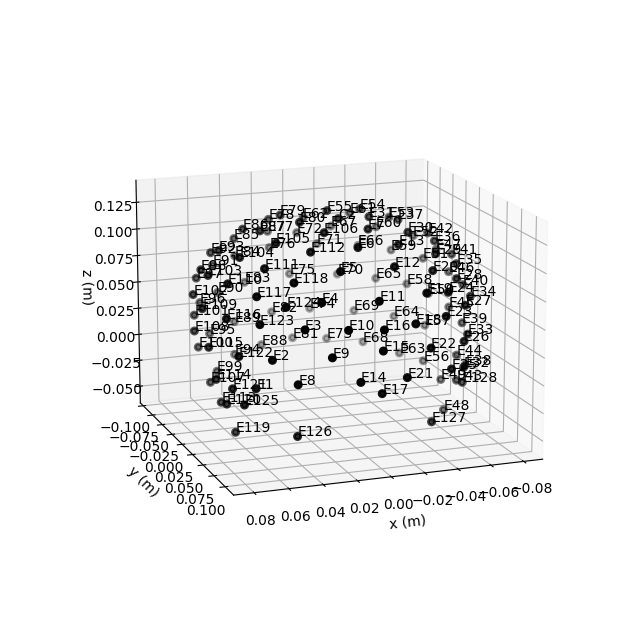

In [24]:

# kind = kinda standard which has 3D coordinates for 128 electrodes and 3 default things
montage_plot = mne.channels.make_standard_montage(kind= "GSN-HydroCel-129")  
# Note: By default, the 3d plots displayed here does not show the 3rd axis, thus require a
# a package called qt, can be called with %matplotlib qt
%matplotlib notebook
fig = montage_plot.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)


## Raw data in time domain

In [9]:
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font
from plotly import tools
from plotly import graph_objects
import chart_studio.plotly as py
import matplotlib.pyplot as plt

n_channels = 20
start, stop = raw.time_as_index([0, 5])
picks = mne.pick_channels(raw.ch_names, include=raw.ch_names[:n_channels], exclude=[])


data, times = raw[picks[:n_channels], start:stop]
ch_names = [raw.info['ch_names'][p] for p in picks[:n_channels]]
#ch_names


step = 1. / n_channels
kwargs = dict(domain=[1 - step, 1], showticklabels=False, zeroline=False, showgrid=False)

# create objects for layout and traces
layout = Layout(yaxis=YAxis(kwargs), showlegend=False)
traces = [Scatter(x=times, y=data.T[:, 0])]

# loop over the channels
for ii in range(1, n_channels):
        kwargs.update(domain=[1 - (ii + 1) * step, 1 - ii * step])
        layout.update({'yaxis%d' % (ii + 1): YAxis(kwargs), 'showlegend': False})
        traces.append(Scatter(x=times, y=data.T[:, ii], yaxis='y%d' % (ii + 1)))

# add channel names using Annotations
annotations = Annotations([Annotation(x=-0.06, y=0, xref='paper', yref='y%d' % (ii + 1),
                                      text=ch_name, font=Font(size=9), showarrow=False)
                          for ii, ch_name in enumerate(ch_names)])
layout.update(annotations=annotations)

# set the size of the figure and plot it
layout.update(autosize=False, width=1000, height=600)
#fig = Figure(data=Data(traces), layout=layout)
#fig.show()
#fig.write_html("raw_time_domain.html")


/usr/lib/python3/dist-packages/plotly/graph_objs/_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/usr/lib/python3/dist-packages/plotly/graph_objs/_deprecations.py:322: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


/usr/lib/python3/dist-packages/plotly/graph_objs/_deprecations.py:143: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation


/usr/lib/python3/dist-packages/plotly/graph_objs/_deprecations.py:62: DeprecationWarning:

plotly.graph_objs.Annotations is deprecated.
Please replace it w

Layout({
    'annotations': [{'font': {'size': 9},
                     'showarrow': False,
                     'text': 'E2',
                     'x': -0.06,
                     'xref': 'paper',
                     'y': 0,
                     'yref': 'y'},
                    {'font': {'size': 9},
                     'showarrow': False,
                     'text': 'E3',
                     'x': -0.06,
                     'xref': 'paper',
                     'y': 0,
                     'yref': 'y2'},
                    {'font': {'size': 9},
                     'showarrow': False,
                     'text': 'E4',
                     'x': -0.06,
                     'xref': 'paper',
                     'y': 0,
                     'yref': 'y3'},
                    {'font': {'size': 9},
                     'showarrow': False,
                     'text': 'E5',
                     'x': -0.06,
                     'xref': 'paper',
                     'y': 0,
            

# Epoch (ing) the raw data

In [9]:
epochs = mne.Epochs(raw, events[:-1], [20,30,90], tmin=0, tmax=20,preload=True,baseline=(0,None))
epochs_resampled = epochs.resample(250)
np.shape(epochs_resampled.load_data())


Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 12 events and 10001 original time points ...
1 bad epochs dropped


(11, 92, 5000)

In [52]:
for i in epochs_resampled[0]:
    print(i)

[[-3.58409631e+00 -8.18878558e-01  2.81844831e+00 ...  4.52789963e-03
   2.07484308e+00  3.93024530e+00]
 [ 6.53901394e+00  1.27377559e+00 -2.94062442e+00 ... -8.92677892e+00
  -9.67254170e+00 -1.06168450e+01]
 [-6.93891178e+00 -1.98165323e+00  3.12380739e+00 ...  5.18470655e+00
   8.01368388e+00  9.22337828e+00]
 ...
 [ 4.10320804e+00  6.48407734e-01 -1.91441106e+00 ... -6.71186813e+00
  -6.69504774e+00 -7.49493978e+00]
 [ 3.65310369e+00  9.82614309e-01 -1.61844898e+00 ... -5.19645865e+00
  -5.63366523e+00 -5.53457346e+00]
 [ 2.24960874e+01 -6.14398001e+00  3.39749992e+00 ... -2.91433743e-03
   2.91632953e-03 -2.91832477e-03]]


# Topo Plot

In [53]:
layout = mne.find_layout(epochs.info)
##epochs.average().plot_topo(layout=layout)


# Plotting events

In [54]:
##mne.viz.plot_events(events[:-1], sfreq=raw.info['sfreq'])
#The last event 20 falls on 174120 and the last sample is 176386. That's just 4 seconds before the end of the EEG

# Raw PSD 

In [55]:
##mne.viz.plot_raw_psd(raw,tmax=40,fmax=40,picks=['E22','E20','E23'])

# Covariance

In [10]:
# Plotting covariance
covariance = mne.compute_covariance(
    epochs_resampled, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

Computing rank from data with rank=None
    Using tolerance 3e-07 (2.2e-16 eps * 11 dim * 1.2e+08  max singular value)
    Estimated rank (eeg): 11
    EEG: rank 11 computed from 91 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 91 -> 11


<ipython-input-10-0a62af761410>:2: RuntimeWarning: Too few samples (required : 460 got : 11), covariance estimate may be unreliable
  covariance = mne.compute_covariance(


Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 11
log-likelihood on unseen data (descending order):
   shrunk: -217.287
   empirical: -246.661
selecting best estimator: shrunk
[done]


# Topomap PSD

In [57]:
#epochs
##mne.viz.plot_epochs_psd_topomap(epochs['20']) # Eyes open

# PSD plot for the electrodes located in Occipital lobe

In [58]:
##for i in range(0,5): #0 is 90 = beginning of EEG, so skipped
    #plt.title('event ={}. Note: open = 20'.format(events[i][2])) this works nicely if plotted through qt
  ##  print("\t\t\tEVENT IN THE GRAPH BELOW IS = {}".format(events[i][2]))
    ##print("\t\t\tNOTE, EYES OPEN = 20 & EYES CLOSE = 30")
    ##print("\t\t\tOnset at {}s".format(events[i][0]/500))
    ##mne.viz.plot_raw_psd(raw,tmin= events[i][0]/500,tmax=events[i+1][0]/500,fmax=40,picks=['E70','E75','E83'])

    
# Types of waves: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/brain-waves
    


In [59]:
#%matplotlib inline
#for i in range(1,5): #0 is 90 = beginning of EEG, so skipped
    #plt.title('event ={}. Note: open = 20'.format(events[i][2])) this works nicely if plotted through qt
    #print("\t\t\tEVENT IN THE GRAPH BELOW IS = {}".format(events[i][2]))
    #print("\t\t\tNOTE, EYES OPEN = 20 & EYES CLOSE = 30")
    #mne.viz.plot_raw_psd(raw,tmin= events[i][0]/500,tmax=events[i+1][0]/500,fmax=40,picks=['E34','E33'])


# Source Reconstruction

### Setting up BEM model

In [12]:
from mne.datasets import fetch_fsaverage

import os.path as op
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif') # BEM model is called faverage I guess

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


### Forward Solution

In [13]:
fwd_model = mne.make_forward_solution(raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=5.0)

Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  91 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BE

### Inverse operator with the known forward operator

In [14]:
from mne.minimum_norm import make_inverse_operator, apply_inverse, apply_inverse_epochs

inverse_operator = make_inverse_operator(raw.info, fwd_model, covariance)


Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.29 (2.2e-16 eps * 91 dim * 1.4e+13  max singular value)
    Estimated rank (eeg): 11
    EEG: rank 11 computed from 91 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of

### Applying Inverse

In [15]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2


In [73]:
vertno_max, time_max = stc[0].get_peak()
%matplotlib qt
%gui qt # Solves the black-screen on mayavi front. This 5 letters, 2 words took me hours and hours to figure out :D

fig, ax = plt.subplots()
ax.plot(1e3 * stc[0].times, stc[0].data[::100, :].T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)
brain = stc[0].plot(subjects_dir=subjects_dir, initial_time=time_max, time_unit='s',hemi='both')
#surfer_kwargs = dict(
 #   hemi='both', subjects_dir=subjects_dir,
  #  clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
   # initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
#brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',scale_factor=0.6, alpha=0.5)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='red',scale_factor=0.6, alpha=0.5)

brain.add_text(0.1, 0.9, 'eLORETA', 'title' ,font_size=14)



ERROR:root:Invalid GUI request 'qt # Solves the black-screen on mayavi front. This 5 letters, 2 words took me hours and hours to figure out :D', valid ones are:dict_keys(['inline', 'nbagg', 'notebook', 'ipympl', 'widget', None, 'qt4', 'qt', 'qt5', 'wx', 'tk', 'gtk', 'gtk3', 'osx', 'asyncio'])


Using control points [7.90981298e-06 8.65465463e-06 1.43173850e-05]


# Gearing up for computing PSD at source level

In [14]:
from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs
from mne.datasets import sample

In [ ]:
#stc2=stc[0].in_label(mne.Label(inverse_operator['src'][0]['vertno'], hemi='lh') +
    #              mne.Label(inverse_operator['src'][1]['vertno'], hemi='rh'))
    

data_path = sample.data_path()
label_name ='Vis-rh.label' # Have to use 2 labels at the same, but will deal with this later
fname_label = data_path + '/MEG/sample/labels/%s' % label_name
label = mne.read_label(fname_label)

stcs = compute_source_psd_epochs(epochs_resampled[3], inverse_operator, lambda2=lambda2,
                                 method=method, fmin=0, fmax=40, label=label,
                                 return_generator=True)


# Averaging the epochs transform into an evoked array which is not the expected data but we have to average
# Here we add directly and average them based on the number of events
psd_avg = 0.
for i, stc_loop in enumerate(stcs):
    psd_avg += stc_loop.data
    print(stc_loop)






Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...


In [1]:
brain = stc_loop.plot(
        subject=subject,
        colormap='inferno')


NameError: name 'stc_loop' is not defined

In [53]:
stcs = apply_inverse_epochs(epochs_resampled['20'], inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

label = mne.read_label(fname_label)

src = inverse_operator['src']  # the source space used
seed_ts = mne.extract_label_time_course(stcs, label, src, mode='mean_flip',
                                        verbose='error')

In [44]:
stcs = apply_inverse_epochs(epochs_resampled['20'], inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)
comb_ts = list(zip(seed_ts, stcs))

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 11 (80 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 5
Processing epoch : 2 / 5
Processing epoch : 3 / 5
Processing epoch : 4 / 5
Processing epoch : 5 / 5


In [39]:
label

<Label | unknown, 'Vis-rh', rh : 623 vertices>

In [ ]:
stcs = apply_inverse_epochs(epochs_resampled, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

src = inverse_operator['src']  # the source space used
seed_ts = mne.extract_label_time_course(stcs, label, src, mode='mean_flip',
                                        verbose='error')

stcs = apply_inverse_epochs(epochs_resampled, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)
comb_ts = list(zip(seed_ts, stcs))

In [ ]:
comb_ts

Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 11 (80 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 11
Using 78 tapers with bandwidth 4.0 Hz on 5 epochs


In [49]:
stc_psd = np.mean(stc_psd)

In [50]:
stc_psd

<SourceEstimate | 210 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 40000.0 (ms), tstep : 50.0 (ms), data shape : (210, 801), ~1.3 MB>

In [ ]:
def plot_band(band):
    """Plot activity within a frequency band on the subject's brain."""
    #title = "%s %s\n(%d-%d Hz)" % ((titles, band,) + freq_bands[band])
    topos[band].plot_topomap(
        times=0., scalings=1., cbar_fmt='%0.1f', vmin=0, cmap='inferno',
        )

fig_theta, brain_theta = plot_band('alpha')

In [51]:
brain = stc_psd.plot(
        subject=subject, subjects_dir=subjects_dir, views='cau', hemi='both',
         colormap='inferno',
        time_viewer=False, show_traces=False,
        clim=dict(kind='percent', lims=(70, 85, 99)), smoothing_steps=10)
brain.show_view(dict(azimuth=0, elevation=0), roll=0)

Using control points [2.98135283e-11 8.73588607e-11 1.59108586e-09]


((0.0, 0.0, 432.1112365722656, array([-0.59938049,  0.        ,  0.        ])),
 0.0)

In [17]:
from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs

print(__doc__)
from mne.datasets import sample
data_path = sample.data_path()
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_raw-eve.fif'
label_name = 'Vis-rh'
fname_label = data_path + '/MEG/sample/labels/%s.label' % label_name
subjects_dir = data_path + '/subjects'

event_id, tmin, tmax = 1, -0.2, 0.5
snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Load data
inverse_operator = read_inverse_operator(fname_inv)
label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Set up pick list
include = []
raw.info['bads'] += ['EEG 053']  # bads + 1 more

# pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       include=include, exclude='bads')
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                                                    eog=150e-6))

# define frequencies of interest
fmin, fmax = 0., 70.
bandwidth = 4.  # bandwidth of the windows in Hz

Automatically created module for IPython interactive environment
Reading inverse operator decomposition from /homes/v20subra/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance informatio

In [25]:
n_epochs_use = 10
stcs = compute_source_psd_epochs(epochs[:n_epochs_use], inverse_operator,
                                 lambda2=lambda2,
                                 method=method, fmin=fmin, fmax=fmax,
                                 bandwidth=bandwidth, label=label,
                                 return_generator=True, verbose=True)

# compute average PSD over the first 10 epochs
psd_avg = 0.
for i, stc in enumerate(stcs):
    psd_avg += stc.data
    
psd_avg /= n_epochs_use
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg 

Considering frequencies 0 ... 70 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 21 -> 21
Using 2 tapers with bandwidth 4.0 Hz on at most 10 epochs


<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax : 69905.30765198189 (ms), tstep : 1426.6389316731 (ms), data shape : (7, 50), ~3 kB>
<SourceEstimate | 7 vertices, subject : sample, tmin : 0.0 (ms), tmax 

In [40]:
brain = stc.plot(initial_time=10., hemi='rh', views='lat',  # 10 HZ
                 clim=dict(kind='value', lims=(20, 40, 60)),
                 smoothing_steps=3, subjects_dir=subjects_dir)
brain.add_label(label, borders=True, color='k')

In [86]:
stc[0].vertices

[array([    0,     1,     2, ..., 10239, 10240, 10241]),
 array([    0,     1,     2, ..., 10239, 10240, 10241])]

In [29]:
for i, stc in enumerate(stcs):
    psd_avg += stc.data
    print(stc)